In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Load responses
df = pd.read_csv('pilot_data_raw.csv')

In [2]:
## INITIAL CLEANING ##
# delete row index 0 and 1
df = df.drop(1)
df = df.drop(0)

# delete uneeded columns
df = df.drop(columns=["Status", "IPAddress", "Progress", "Duration (in seconds)", "Finished", "RecordedDate", "RecipientLastName", "RecipientFirstName", "RecipientEmail", "ExternalReference", "LocationLatitude", "LocationLongitude", "DistributionChannel", "UserLanguage"])

# give the number of rows and columns in the raw dataset
print("The number of raw observations is: ", df.shape[0])
print("The number of raw columns is: ", df.shape[1])

The number of raw observations is:  2382
The number of raw columns is:  51


In [3]:
## ATTENTION CHECK AND ATTRITION RATE ##

# print attention check numbers:
failed_attention_check = df[(df['Attention Check'] != 'On-line sources only')].shape[0]
proportion_failed = failed_attention_check / df.shape[0]
print(f"The number of participants who failed the attention check is: {failed_attention_check} ({proportion_failed:.2%})")

# print the attrition rate numbers
attrition_count = df[(df['Attention Check'] == 'On-line sources only') & (df['authorship'].isna())].shape[0]
attrition_rate = attrition_count / df.shape[0] * 100
print(f"The number of participants who passed the attention check but later dropped out is: {attrition_count} (Attrition rate: {attrition_rate:.2f}%)")

# filter out people who failed the attention check:
df = df[(df['Attention Check'] == 'On-line sources only')]

# filter out attrition cases
df = df[df['authorship'].notna()]

The number of participants who failed the attention check is: 57 (2.39%)
The number of participants who passed the attention check but later dropped out is: 0 (Attrition rate: 0.00%)


In [4]:
## CREATE OUTCOME VARIABLE ##

# remove the suffix _1 any column that ends in _1
df.columns = df.columns.str.replace('_1', '')

# for every column ending in -2, create a new column with the same name but appending -2-reversed and make the value 100-the value
for col in df.columns:
    if col.endswith('-2'):
        new_col = col.replace('-2', '-2-reversed')
        df[new_col] = 100 - pd.to_numeric(df[col], errors='coerce')

# create the following columns:
df['medicaid_mean'] = df[['medicaid-1', 'medicaid-2-reversed', "medicaid-3", "medicaid-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['veterans_mean'] = df[['veterans-1', 'veterans-2-reversed', "veterans-3", "veterans-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['pensions_mean'] = df[['pensions-1', 'pensions-2-reversed', "pensions-3", "pensions-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['foreign_aid_mean'] = df[['foreign_aid-1', 'foreign_aid-2-reversed', "foreign_aid-3", "foreign_aid-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['confinement_mean'] = df[['confinement-1', 'confinement-2-reversed', "confinement-3", "confinement-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['suicide_mean'] = df[['suicide-1', 'suicide-2-reversed', "suicide-3", "suicide-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['border_mean'] = df[['border-1', 'border-2-reversed', "border-3", "border-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)  
df['felon_voting_mean'] = df[['felon_voting-1', 'felon_voting-2-reversed', "felon_voting-3", "felon_voting-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['affirmative_action_mean'] = df[['affirmative_action-1', 'affirmative_action-2-reversed', "affirmative_action-3", "affirmative_action-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['electoral_college_mean'] = df[['electoral_college-1', 'electoral_college-2-reversed', "electoral_college-3", "electoral_college-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

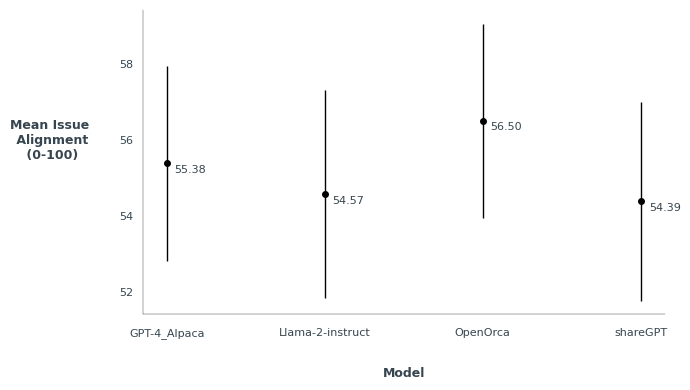

In [5]:
# Calculate the mean across issues for each participant
mean_cols = ['medicaid_mean', 'veterans_mean', 'pensions_mean', 'foreign_aid_mean', 'confinement_mean', 'suicide_mean', 'border_mean', 'felon_voting_mean', 'affirmative_action_mean', 'electoral_college_mean']

df['mean_alignment'] = df[mean_cols].mean(axis=1)

# Group by model type and calculate mean and standard error for the mean alignment
grouped = df.groupby('model')['mean_alignment'].agg(['mean', 'count', 'std'])
grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])  # Standard Error
grouped['ci95_hi'] = grouped['mean'] + 1.96*grouped['se']
grouped['ci95_lo'] = grouped['mean'] - 1.96*grouped['se']

# Reset index to make 'model_type' a column
grouped_reset = grouped.reset_index()

# Plotting
plt.figure(figsize=(7, 4))

# Create a list of x positions for each model
x_positions = range(len(grouped_reset['model']))

# Plot error bars with smaller markers indicating the mean
plt.errorbar(x_positions, grouped_reset['mean'], 
             yerr=[grouped_reset['mean'] - grouped_reset['ci95_lo'], grouped_reset['ci95_hi'] - grouped_reset['mean']], 
             fmt='o', capsize=0.0, color='black', elinewidth=1, markersize=4)  # Reduced marker size

# Set xticks to be model names
plt.xticks(x_positions, grouped_reset['model'], fontsize=8)
plt.yticks(fontsize=8)

# Remove x-axis ticks
plt.tick_params(axis='x', length=0, pad=10, colors='#36454F')
plt.tick_params(axis='y', colors='#36454F')

# Set yticks to be 4
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().yaxis.set_tick_params(width=0)

# Add labels for the mean markers
for i, mean in enumerate(grouped_reset['mean']):
    plt.text(i+.05, mean-.30, f'{mean:.2f}', ha='left', va='bottom', color='#36454F', fontsize=8)

plt.xlabel('Model', labelpad = 20, fontsize = 9, weight='bold', color='#36454F')
plt.ylabel('Mean Issue\n Alignment\n (0-100)', rotation = 0, labelpad = 50, fontsize = 9, weight='bold', color='#36454F')

# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set thickness of x and y axis
plt.gca().spines['bottom'].set_linewidth(0.25)
plt.gca().spines['left'].set_linewidth(0.25)

plt.tight_layout()

# Save the plot as a pdf
plt.savefig('pilot_results.pdf')

# Then display the plot
plt.show()


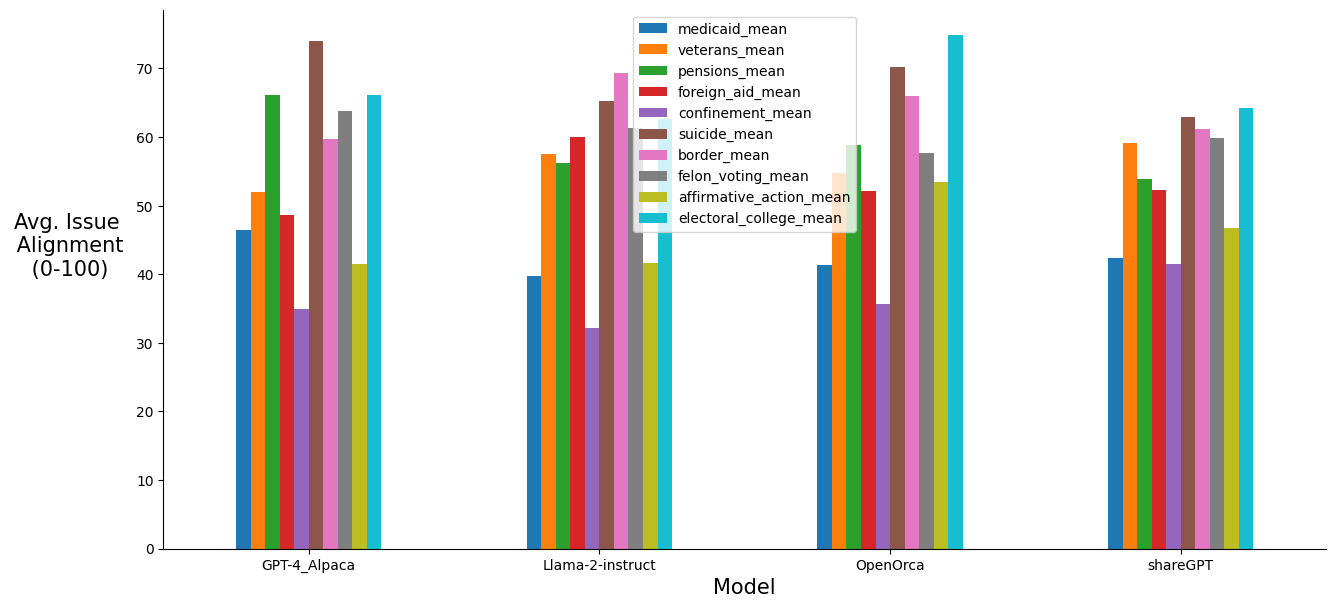

In [6]:
# VISUALIZE DATA ##

mean_cols = ['medicaid_mean', 'veterans_mean', 'pensions_mean', 'foreign_aid_mean', 'confinement_mean', 'suicide_mean', 'border_mean', 'felon_voting_mean', 'affirmative_action_mean', 'electoral_college_mean']

# group by 'model' column and calculate mean
grouped = df.groupby('model')[mean_cols].mean()

sns.set_palette('tab10')

# plot
ax = grouped.plot(kind='bar', figsize=(15, 7))
plt.ylabel('Avg. Issue\n Alignment\n (0-100)', rotation = 0, labelpad = 50, fontsize = 15)
plt.xlabel('Model', fontsize = 15)
plt.xticks(rotation=0)

# remove the top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

